# CHALLENGE NEXIALOG

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.ensemble import IsolationForest
import plotly.express as px
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
file_path = filepath = r"/content/drive/MyDrive/CHALLENGE_NEXIALOG/DATA/Copie de 250327_tests_fixe_dns_sah_202412_202501.parquet" #local
df = pd.read_parquet(file_path,engine="pyarrow")

## EDA

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9096908 entries, 0 to 9096907
Data columns (total 18 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_hour            datetime64[ns]
 1   code_departement     object        
 2   olt_model            object        
 3   olt_name             object        
 4   peag_nro             object        
 5   boucle               object        
 6   dsp                  object        
 7   pebib                object        
 8   pop_dns              object        
 9   nb_test_dns          int64         
 10  avg_dns_time         float64       
 11  std_dns_time         float64       
 12  nb_test_scoring      int64         
 13  avg_latence_scoring  float64       
 14  std_latence_scoring  float64       
 15  avg_score_scoring    float64       
 16  std_score_scoring    float64       
 17  nb_client_total      int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(8)
memory u

In [46]:
olt_peag_counts = df.groupby("olt_name")["peag_nro"].nunique()
nb_olt_multi_peag = (olt_peag_counts > 1).sum()
print(f"Nombre d'OLT ayant plus d'un PEAG associé : {nb_olt_multi_peag}")
nb_olt_total = df["olt_name"].nunique()
print(f"Nombre total d'OLT : {nb_olt_total}")

Nombre d'OLT ayant plus d'un PEAG associé : 152
Nombre total d'OLT : 6061


In [48]:
random_olt = olt_peag_counts[olt_peag_counts > 1].sample(1).index[0]
print(f"OLT aléatoire avec plusieurs PEAG : {random_olt}")



OLT aléatoire avec plusieurs PEAG : 38_olt_2150


In [49]:
df[df["olt_name"] == random_olt]["peag_nro"].unique()


array(['38_peag_1110', '38_peag_3101'], dtype=object)

In [52]:
df.head(3)


,date_hour,code_departement,olt_model,olt_name,peag_nro,boucle,dsp,pebib,pop_dns,nb_test_dns,avg_dns_time,std_dns_time,nb_test_scoring,avg_latence_scoring,std_latence_scoring,avg_score_scoring,std_score_scoring,nb_client_total
0,2024-12-01,01,M11,01_olt_3,01_peag_3,BU1464,dsp_1,69_pebib_3,69_lyon,23,6.845641,0.377309,9,11.437500,0.281250,3.258823,0.375156,32
1,2024-12-01,01,M11,01_olt_4,01_peag_3,BU1464,dsp_1,69_pebib_3,69_lyon,10,7.060350,0.392031,4,12.656250,2.079476,2.576471,1.272078,14
2,2024-12-01,01,M13,01_olt_5,01_peag_4,BU458,dsp_1,None,69_lyon,28,2.787241,0.410001,16,8.542969,0.512205,2.868750,0.714469,44


In [53]:
df["date_hour"].sample(10)

,date_hour
5203338,2025-01-04 07:00:00
3809369,2024-12-25 18:00:00
5591240,2025-01-07 02:00:00
3443377,2024-12-23 08:00:00
5250340,2025-01-04 15:00:00
8397330,2025-01-27 02:00:00
382626,2024-12-03 16:00:00
7055212,2025-01-17 13:00:00
3799546,2024-12-25 16:00:00
565085,2024-12-04 21:00:00


In [54]:
df["date_hour"] = df["date_hour"].astype(str)
df["date_hour"] = pd.to_datetime(df["date_hour"], format="mixed")

## DATA VIZ

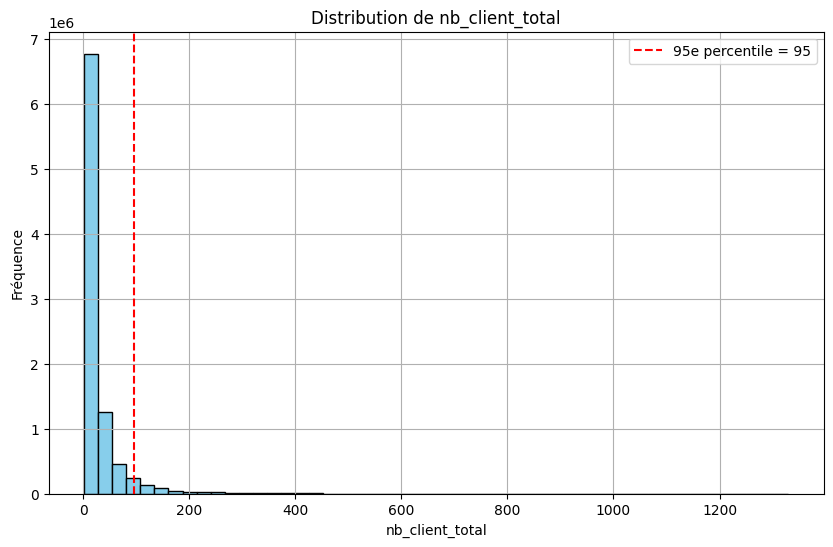

In [55]:
q95 = df["nb_client_total"].quantile(0.95)

plt.figure(figsize=(10, 6))
plt.hist(df["nb_client_total"], bins=50, color="skyblue", edgecolor="k")
plt.axvline(q95, color="red", linestyle="--", label=f"95e percentile = {q95:.0f}")
plt.title("Distribution de nb_client_total")
plt.xlabel("nb_client_total")
plt.ylabel("Fréquence")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
print(df["nb_client_total"].describe())
q95 = df["nb_client_total"].quantile(0.95)
q005 = df["nb_client_total"].quantile(0.05)
print(f"95e percentile : {q95}")
print(f"5e percentile : {q005}")

count    9.096908e+06
mean     2.527975e+01
std      3.856525e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.200000e+01
75%      2.800000e+01
max      1.330000e+03
Name: nb_client_total, dtype: float64
95e percentile : 95.0
5e percentile : 1.0


## **DIVISION DF_DNS / DF_SCORING**

In [57]:
df_dns = df.drop(["nb_test_scoring", "avg_latence_scoring", "std_latence_scoring", "avg_score_scoring", "std_score_scoring"], axis=1)

In [58]:
df_scoring = df.drop(["pop_dns", "nb_test_dns", "avg_dns_time", "std_dns_time"], axis=1)

In [59]:
print(df["date_hour"].isna().sum())
df.dtypes
df['date_hour'].head()

0


,date_hour
0,2024-12-01
1,2024-12-01
2,2024-12-01
3,2024-12-01
4,2024-12-01


### EDA DF_DNS

In [60]:
df_dns.nunique()

,0
date_hour,1488
code_departement,96
olt_model,7
olt_name,6061
peag_nro,3176
boucle,537
dsp,32
pebib,211
pop_dns,8
nb_test_dns,579


In [61]:
df_dns.isna().sum()

,0
date_hour,0
code_departement,117
olt_model,8095
olt_name,0
peag_nro,7
boucle,7
dsp,0
pebib,4056844
pop_dns,716932
nb_test_dns,0


In [65]:
df_dns['nb_test_dns'].describe()

,nb_test_dns
count,8.379976e+06
mean,1.790471e+01
std,2.663268e+01
min,1.000000e+00
25%,4.000000e+00
50%,9.000000e+00
75%,2.000000e+01
max,1.275000e+03


In [66]:
df_dns = df_dns[df_dns.nb_test_dns > 0]


In [67]:
df_dns.isna().sum()

,0
date_hour,0
code_departement,61
olt_model,7124
olt_name,0
peag_nro,4
boucle,4
dsp,0
pebib,3758812
pop_dns,0
nb_test_dns,0


### Histogramme

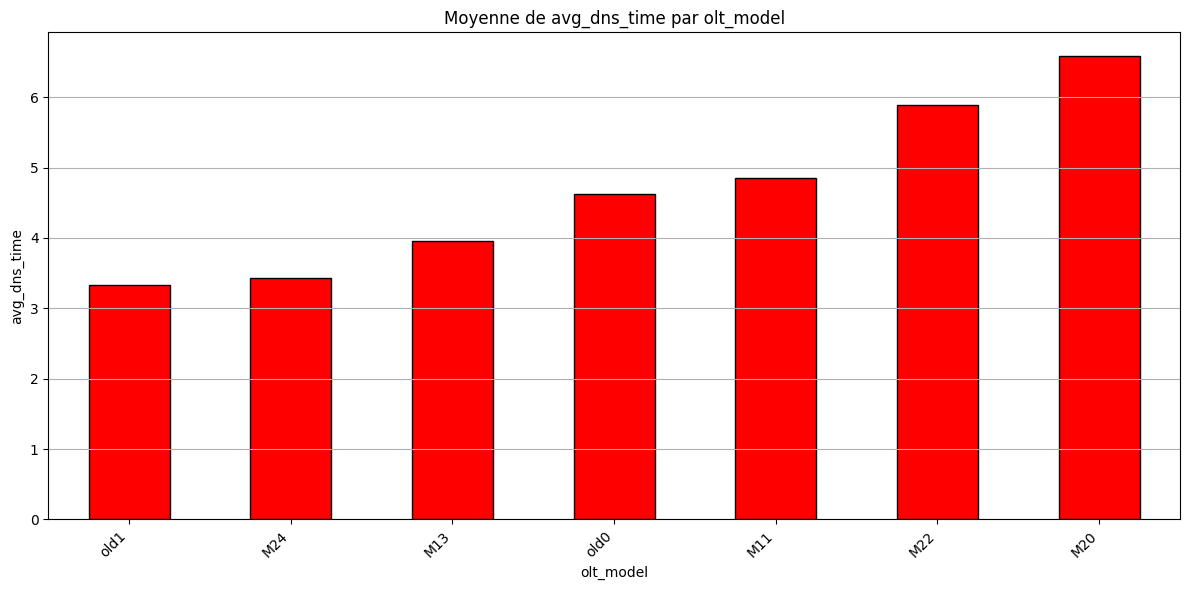

In [20]:
dns_avg_per_model = df_dns.groupby("olt_model")["avg_dns_time"].mean().sort_values()

plt.figure(figsize=(12, 6))
dns_avg_per_model.plot(kind="bar", color="red", edgecolor="black")
plt.title("Moyenne de avg_dns_time par olt_model")
plt.xlabel("olt_model")
plt.ylabel("avg_dns_time")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

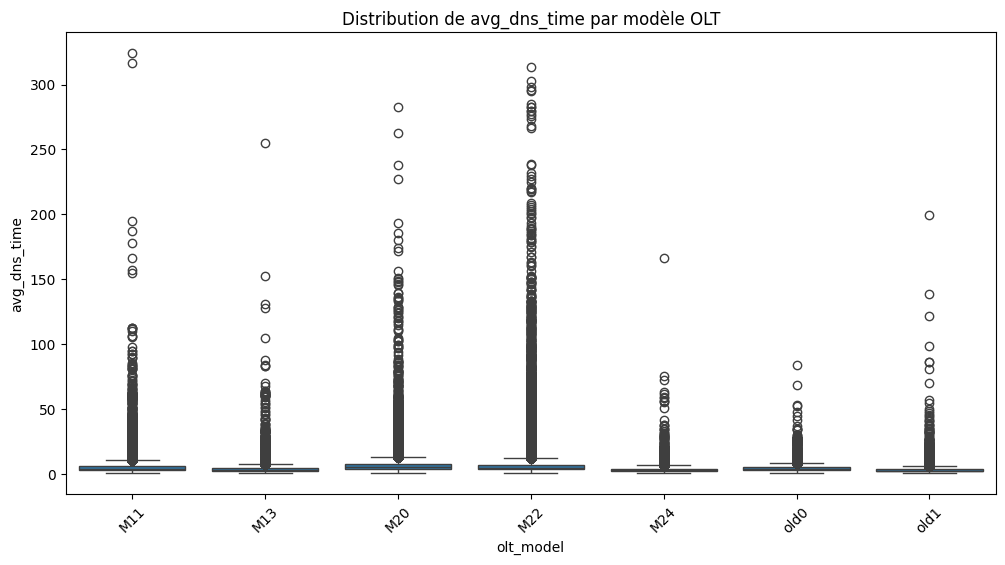

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="olt_model", y="avg_dns_time")
plt.title("Distribution de avg_dns_time par modèle OLT")
plt.xticks(rotation=45)
plt.show()

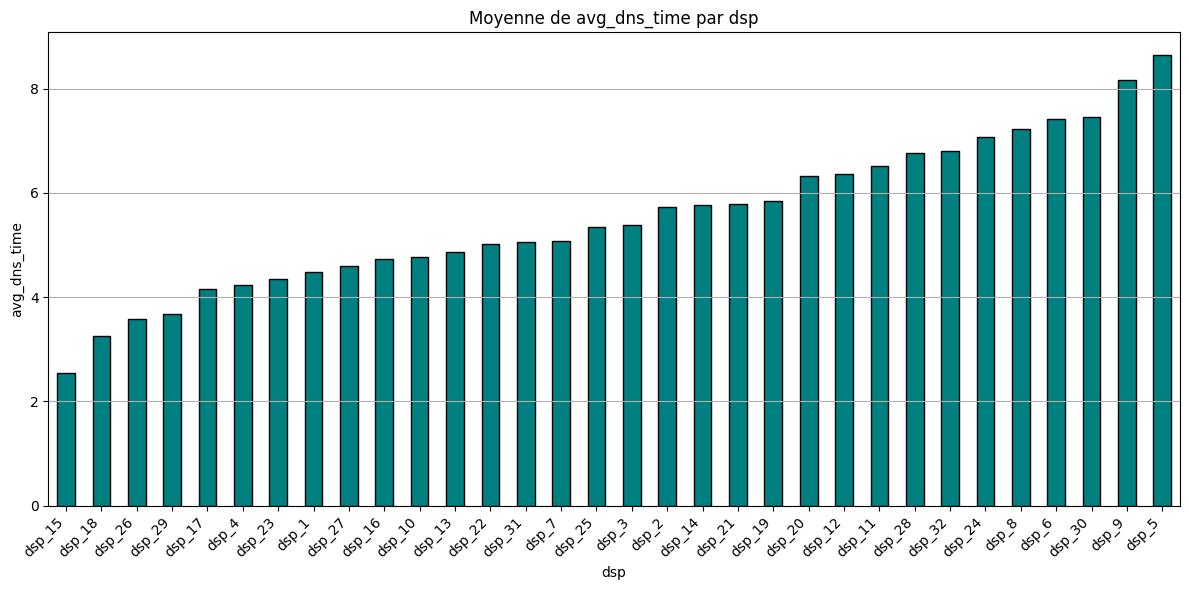

In [22]:
dns_avg_per_model = df_dns.groupby("dsp")["avg_dns_time"].mean().sort_values()

# Tracer le bar plot
plt.figure(figsize=(12, 6))
dns_avg_per_model.plot(kind="bar", color="teal", edgecolor="black")
plt.title("Moyenne de avg_dns_time par dsp")
plt.xlabel("dsp")
plt.ylabel("avg_dns_time")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

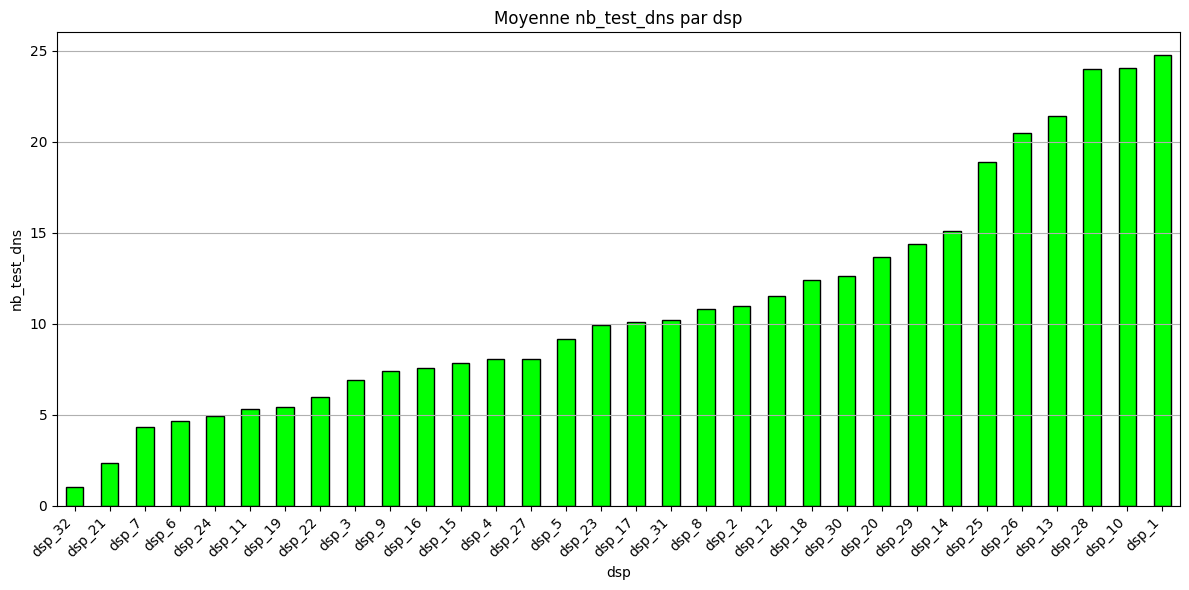

In [23]:
dns_avg_per_model = df_dns.groupby("dsp")["nb_test_dns"].mean().sort_values()

# Tracer le bar plot
plt.figure(figsize=(12, 6))
dns_avg_per_model.plot(kind="bar", color="lime", edgecolor="black")
plt.title("Moyenne nb_test_dns par dsp")
plt.xlabel("dsp")
plt.ylabel("nb_test_dns")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

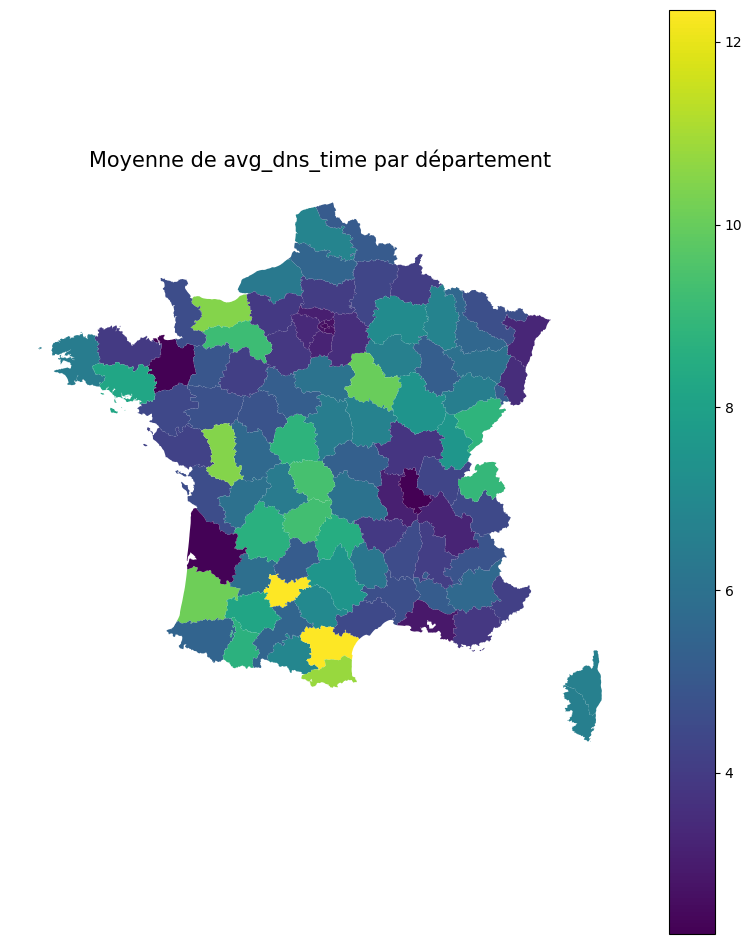

In [24]:

df_dep_avg = df.groupby("code_departement", as_index=False)["avg_dns_time"].mean()

# 2. Charger la carte des départements
gdf_departements = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")

# 3. S'assurer que les deux colonnes sont de type string
gdf_departements["code"] = gdf_departements["code"].astype(str)
df_dep_avg["code_departement"] = df_dep_avg["code_departement"].astype(str)

# 4. Fusion
gdf_merged = gdf_departements.merge(df_dep_avg, left_on="code", right_on="code_departement")

# 5. Carte
fig, ax = plt.subplots(figsize=(10, 12))
gdf_merged.plot(column="avg_dns_time", cmap="viridis", legend=True, ax=ax)
ax.set_title("Moyenne de avg_dns_time par département", fontsize=15)
plt.axis("off")
plt.show()


###  AGREGATION PAR OLT & DATE_HOUR

On va agréger la data dns par olt, pour une vision macro du chemin

In [68]:
df_agg_dns = df_dns.groupby(["olt_name", "date_hour"], as_index=False).agg({
    "avg_dns_time": "mean",
    "std_dns_time": "mean",
    "nb_test_dns": "sum",
    "nb_client_total": "sum"
})

#### FEATURES ENGINEERING

création de variables :
- ratio_test_clients	= Taux de tests effectués par rapport au nombre de clients
- std_over_avg_dns = Coefficient de variation : instabilité du DNS
- avg_dns_per_client = Moyenne du temps DNS ramenée au client
- avg_dns_per_test_dns = Temps DNS moyen par test réalisé.

In [69]:
df_agg_dns["ratio_test_clients"] = df_agg_dns["nb_test_dns"] / df_agg_dns["nb_client_total"]
df_agg_dns["std_over_avg_dns"] = df_agg_dns["std_dns_time"] / df_agg_dns["avg_dns_time"]
df_agg_dns["avg_dns_per_client"] = df_agg_dns["avg_dns_time"] / df_agg_dns["nb_client_total"]
df_agg_dns["avg_dns_per_test_dns"] = df_agg_dns["avg_dns_time"] / df_agg_dns["nb_test_dns"]

In [70]:
df_agg_dns.isna().sum()

,0
olt_name,0
date_hour,0
avg_dns_time,0
std_dns_time,105666
nb_test_dns,0
nb_client_total,0
ratio_test_clients,0
std_over_avg_dns,105666
avg_dns_per_client,0
avg_dns_per_test_dns,0


In [71]:
df_agg_dns = df_agg_dns.dropna()

In [72]:
df_agg_dns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7846099 entries, 0 to 7951760
Data columns (total 10 columns):
 #   Column                Dtype         
---  ------                -----         
 0   olt_name              object        
 1   date_hour             datetime64[ns]
 2   avg_dns_time          float64       
 3   std_dns_time          float64       
 4   nb_test_dns           int64         
 5   nb_client_total       int64         
 6   ratio_test_clients    float64       
 7   std_over_avg_dns      float64       
 8   avg_dns_per_client    float64       
 9   avg_dns_per_test_dns  float64       
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 658.5+ MB


#### ISOLATION FOREST

##### **Contamination = 0.01**

In [73]:
features = ["avg_dns_time", "std_dns_time", "ratio_test_clients", "std_over_avg_dns", "avg_dns_per_client", "avg_dns_per_test_dns", "nb_test_dns", "nb_client_total"]

# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.01, random_state=42)
df_agg_dns["anomaly"] = model.fit_predict(df_agg_dns[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns[df_agg_dns["anomaly"] == -1]


In [74]:
df_agg_dns["anomaly"].value_counts()


,count
anomaly,
1,7767643
-1,78456


In [75]:
olt_sample = '84_olt_5070'
df_olt = df_agg_dns[df_agg_dns["olt_name"] == olt_sample]


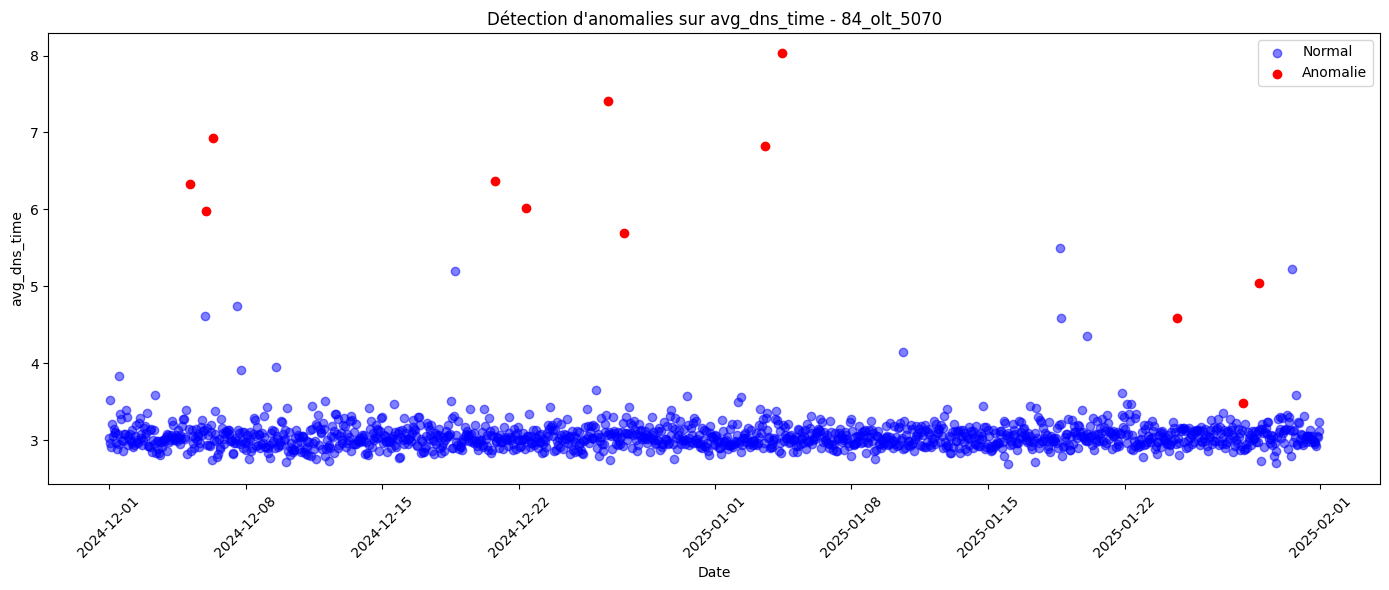

In [76]:
plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##### **Contamination  = auto**

In [77]:
model = IsolationForest(n_estimators=120, contamination="auto", random_state=42)
df_agg_dns["anomaly"] = model.fit_predict(df_agg_dns[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns[df_agg_dns["anomaly"] == -1]


In [78]:
df_olt = df_agg_dns[df_agg_dns["olt_name"] == "84_olt_5070"]

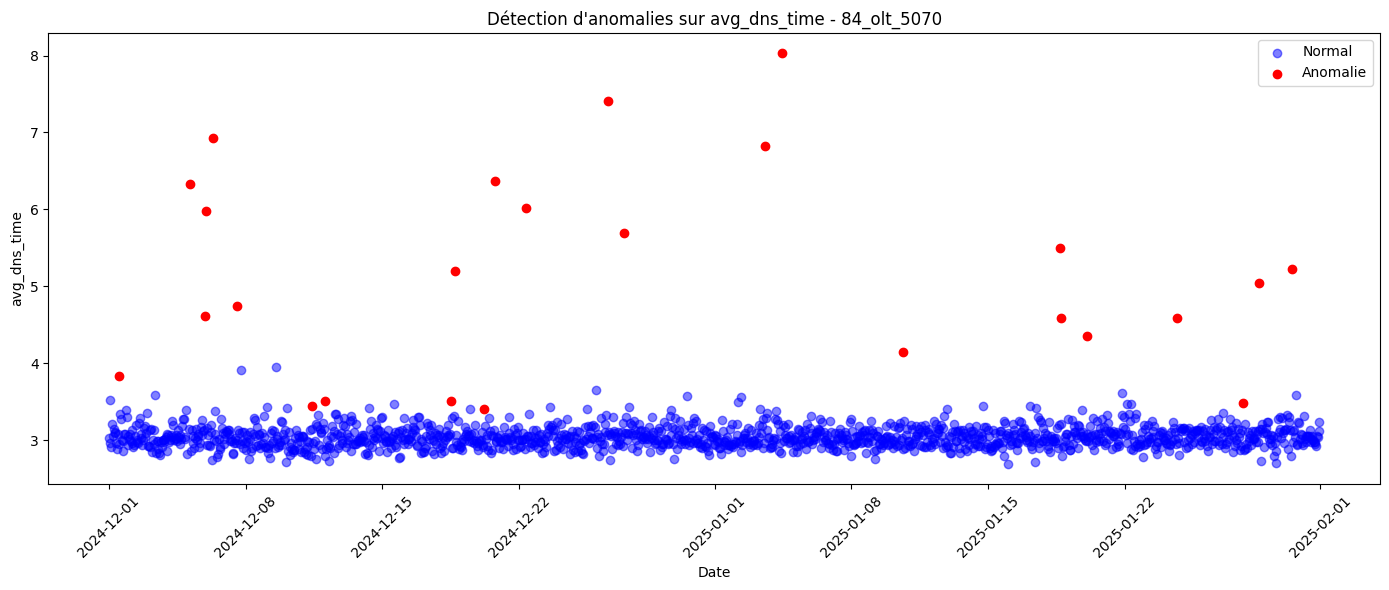

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Avec le parametre auto, on voit que le modèle n'arrive pas vraiment à capter les anomalies puisqu'elles se retrouvent confondues avec les données normales qui se traduit par leur forte proximité avec les points 'bleus'

##### **Contamination = 0.015**

Changement du parametre de contamination (0.01 -> 0.015)

In [80]:
# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.015, random_state=42)
df_agg_dns["anomaly"] = model.fit_predict(df_agg_dns[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns[df_agg_dns["anomaly"] == -1]


In [81]:
df_olt = df_agg_dns[df_agg_dns["olt_name"] == "84_olt_5070"]

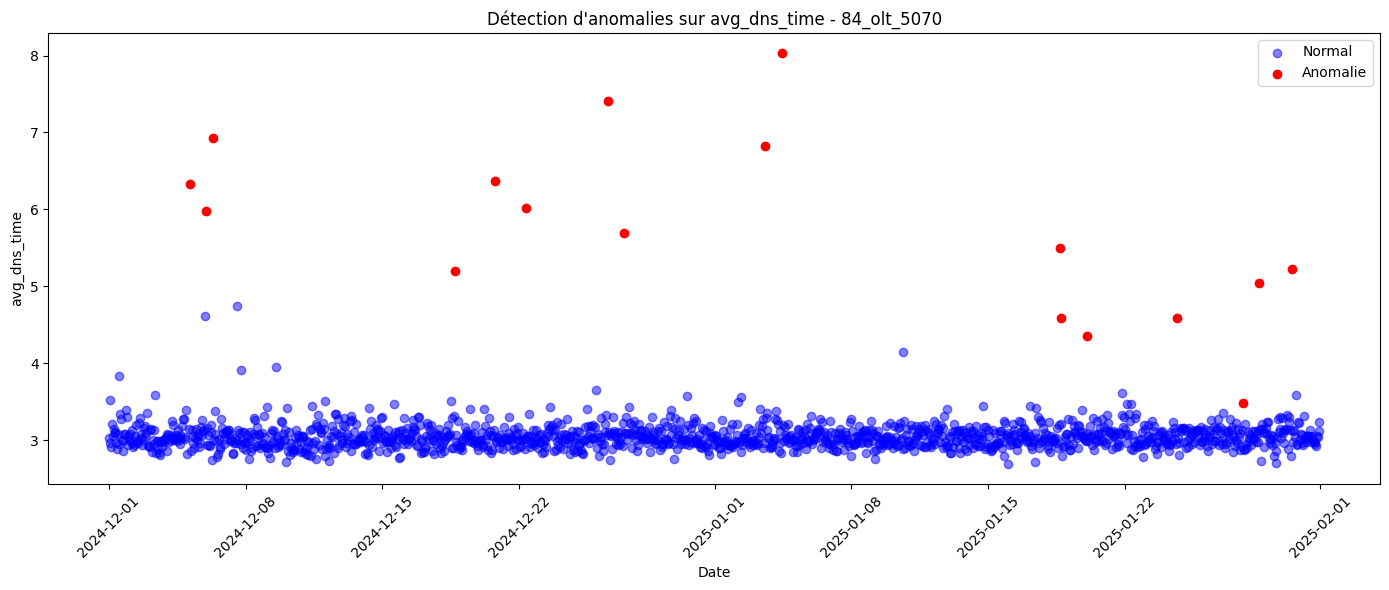

In [82]:
plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 7846099 entries, 0 to 7951760
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   olt_name              object        
 1   date_hour             datetime64[ns]
 2   avg_dns_time          float64       
 3   std_dns_time          float64       
 4   nb_test_dns           int64         
 5   nb_client_total       int64         
 6   ratio_test_clients    float64       
 7   std_over_avg_dns      float64       
 8   avg_dns_per_client    float64       
 9   avg_dns_per_test_dns  float64       
 10  anomaly               int64         
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 718.3+ MB


## LSTM

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0060 - val_loss: 0.0021
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - val_loss: 0.0021
Epoch 12/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0051 - val_l

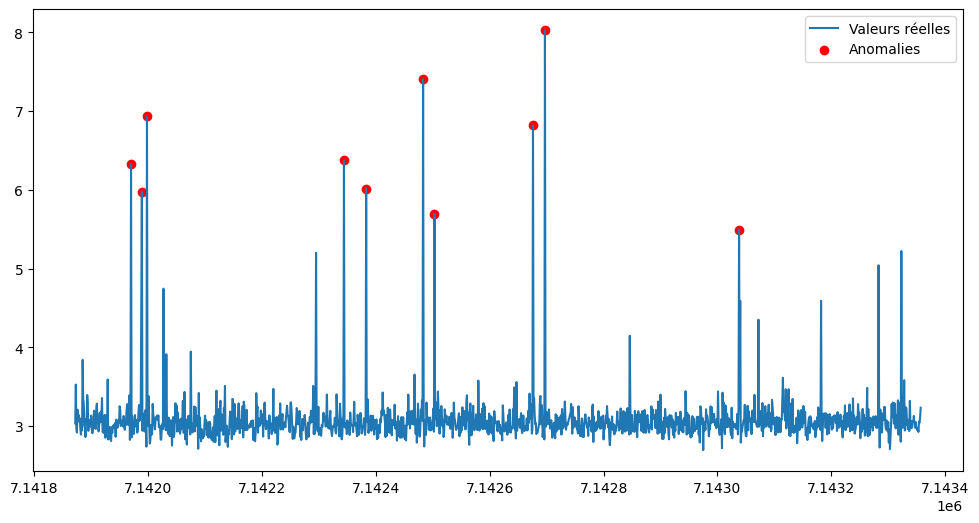

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Supposons que df_plot contient une colonne 'value' avec vos valeurs temporelles
# et 'date_hour' comme index temporel

# Normalisation des données
scaler = MinMaxScaler()
values = df_olt['avg_dns_time'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # A ajuster selon vos données
X, y = create_sequences(scaled_values, SEQ_LENGTH)

# Séparation train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,  # A ajuster
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Prédictions sur l'ensemble de test
test_predictions = model.predict(X_test)
test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)

# Détermination du seuil d'anomalie
threshold = np.max(test_mae_loss)  # Vous pouvez utiliser un percentile (np.percentile)

# Création des séquences pour l'ensemble complet
full_X, full_y = create_sequences(scaled_values, SEQ_LENGTH)
full_predictions = model.predict(full_X)
full_mae_loss = np.mean(np.abs(full_predictions - full_y), axis=1)

# Détection des anomalies
anomalies = full_mae_loss > threshold
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(12, 6))
plt.plot(df_olt['avg_dns_time'], label='Valeurs réelles')
plt.scatter(
    df_olt.index[anomaly_indices + SEQ_LENGTH],  # Ajustement de l'index
    df_olt['avg_dns_time'].iloc[anomaly_indices + SEQ_LENGTH],
    color='red', label='Anomalies'
)

plt.legend()
plt.show()

### AGREGATION PAR PEAG & DATE_HOUR

In [86]:
df_agg_dns_peag = df_dns.groupby(["peag_nro", "date_hour"], as_index=False).agg({
    "avg_dns_time": "mean",
    "std_dns_time": "mean",
    "nb_test_dns": "sum",
    "nb_client_total": "sum"
})

#### FEATURES ENGINEERING

In [89]:
df_agg_dns_peag["ratio_test_clients"] = df_agg_dns_peag["nb_test_dns"] / df_agg_dns_peag["nb_client_total"]

df_agg_dns_peag["std_over_avg_dns"] = df_agg_dns_peag["std_dns_time"] / df_agg_dns_peag["avg_dns_time"]

df_agg_dns_peag["avg_dns_per_client"] = df_agg_dns_peag["avg_dns_time"] / df_agg_dns_peag["nb_client_total"]

df_agg_dns_peag["avg_dns_per_test_dns"] = df_agg_dns_peag["avg_dns_time"] / df_agg_dns_peag["nb_test_dns"]



In [90]:
df_agg_dns_peag.isna().sum()

,0
peag_nro,0
date_hour,0
avg_dns_time,0
std_dns_time,38843
nb_test_dns,0
nb_client_total,0
ratio_test_clients,0
std_over_avg_dns,38843
avg_dns_per_client,0
avg_dns_per_test_dns,0


In [91]:
df_agg_dns_peag = df_agg_dns_peag.dropna()

#### ISOLATION FOREST

##### **Contamination = 0.02**

In [92]:
features = ["avg_dns_time", "std_dns_time", "ratio_test_clients", "std_over_avg_dns", "avg_dns_per_client", "avg_dns_per_test_dns", "nb_test_dns", "nb_client_total"]

# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.02, random_state=42)
df_agg_dns_peag["anomaly"] = model.fit_predict(df_agg_dns_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns_peag[df_agg_dns_peag["anomaly"] == -1]

In [93]:
peag_sample = "84_peag_304"
df_peag = df_agg_dns_peag[df_agg_dns_peag["peag_nro"] == peag_sample]

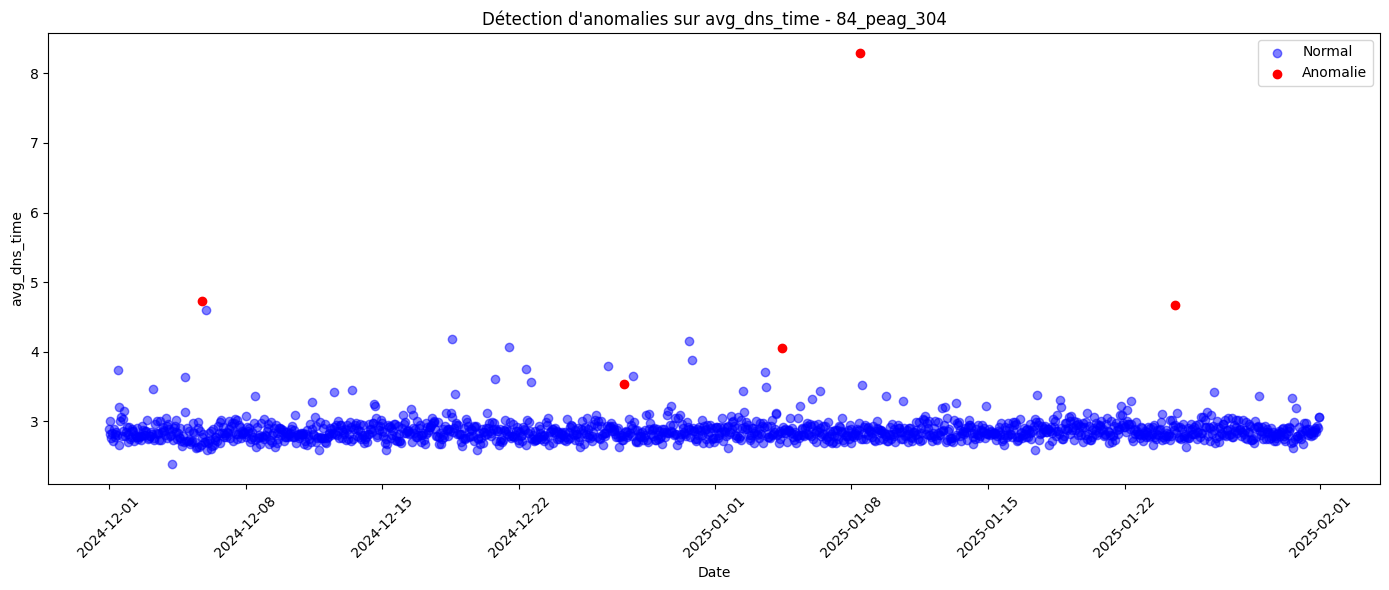

In [94]:
plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Contamination = auto**

In [ ]:
model = IsolationForest(n_estimators=120, contamination='auto', random_state=42)
df_agg_dns_peag["anomaly"] = model.fit_predict(df_agg_dns_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns_peag[df_agg_dns_peag["anomaly"] == -1]

In [ ]:
df_peag = df_agg_dns_peag[df_agg_dns_peag["peag_nro"] == "84_peag_304"]

In [ ]:
plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Contamination = 0.025**

In [ ]:
model = IsolationForest(n_estimators=120, contamination=0.025, random_state=42)
df_agg_dns_peag["anomaly"] = model.fit_predict(df_agg_dns_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns_peag[df_agg_dns_peag["anomaly"] == -1]

In [ ]:
df_peag = df_agg_dns_peag[df_agg_dns_peag["peag_nro"] == "84_peag_304"]

In [ ]:
plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_dns_time"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_dns_time"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_dns_time - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_dns_time")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### LSTM

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - loss: 0.0036 - val_loss: 7.2463e-04
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_loss: 6.9655e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0027 - val_loss: 7.7728e-04
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0020 - val_loss: 7.0989e-04
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0012 - val_loss: 8.3037e-04
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0018 - val_loss: 7.1963e-04
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0011 - val_loss: 6.9801e-04
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0015 - val_loss: 7.0443e-04
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 8.7881e-04 - val_loss: 7.0369e-04
Epoch 10/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0013 - val_loss: 7.3049e-04
Epoch 11/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0016 - val_loss: 6.9912e-04
Epoch 12/20
37/37 ━━━━━━━

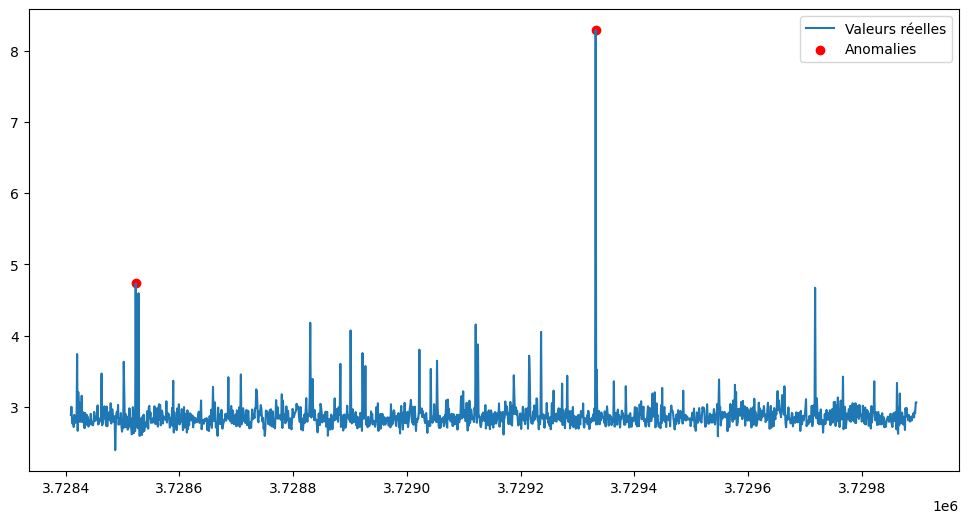

In [101]:
# Normalisation des données
scaler = MinMaxScaler()
values = df_peag['avg_dns_time'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # A ajuster selon vos données
X, y = create_sequences(scaled_values, SEQ_LENGTH)

# Séparation train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,  # A ajuster
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Prédictions sur l'ensemble de test
test_predictions = model.predict(X_test)
test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)

# Détermination du seuil d'anomalie
threshold = np.max(test_mae_loss)  # Vous pouvez utiliser un percentile (np.percentile)

# Création des séquences pour l'ensemble complet
full_X, full_y = create_sequences(scaled_values, SEQ_LENGTH)
full_predictions = model.predict(full_X)
full_mae_loss = np.mean(np.abs(full_predictions - full_y), axis=1)

# Détection des anomalies
anomalies = full_mae_loss > threshold
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(12, 6))
plt.plot(df_peag['avg_dns_time'], label='Valeurs réelles')
plt.scatter(
    df_peag.index[anomaly_indices + SEQ_LENGTH],  # Ajustement de l'index
    df_peag['avg_dns_time'].iloc[anomaly_indices + SEQ_LENGTH],
    color='red', label='Anomalies'
)

plt.legend()
plt.show()

### AGREGATION PAR PEAG & OLT & DATE_HOUR

In [ ]:
df_agg_dns_peag_olt = df_dns.groupby(["peag_nro","olt_name", "date_hour"], as_index=False).agg({
    "avg_dns_time": "mean",
    "std_dns_time": "mean",
    "nb_test_dns": "sum",
    "nb_client_total": "sum"
})

In [103]:
df_agg_dns_peag_olt.head(2)

,peag_nro,olt_name,date_hour,avg_dns_time,std_dns_time,nb_test_dns,nb_client_total
0,01_peag_1,01_olt_1,2024-12-01 00:00:00,4.888439,0.834768,61,86
1,01_peag_1,01_olt_1,2024-12-01 01:00:00,5.293034,0.986387,58,82


#### FEATURES ENGINEERING

In [104]:
df_agg_dns_peag_olt["ratio_test_clients"] = df_agg_dns_peag_olt["nb_test_dns"] / df_agg_dns_peag_olt["nb_client_total"]

df_agg_dns_peag_olt["std_over_avg_dns"] = df_agg_dns_peag_olt["std_dns_time"] / df_agg_dns_peag_olt["avg_dns_time"]

df_agg_dns_peag_olt["avg_dns_per_client"] = df_agg_dns_peag_olt["avg_dns_time"] / df_agg_dns_peag_olt["nb_client_total"]

df_agg_dns_peag_olt["avg_dns_per_test_dns"] = df_agg_dns_peag_olt["avg_dns_time"] / df_agg_dns_peag_olt["nb_test_dns"]


In [105]:
df_agg_dns_peag_olt.isna().sum()

,0
peag_nro,0
olt_name,0
date_hour,0
avg_dns_time,0
std_dns_time,106169
nb_test_dns,0
nb_client_total,0
ratio_test_clients,0
std_over_avg_dns,106169
avg_dns_per_client,0


#### ISOLATION FOREST

In [106]:
features = ["avg_dns_time", "std_dns_time", "ratio_test_clients", "std_over_avg_dns", "avg_dns_per_client", "avg_dns_per_test_dns", "nb_test_dns", "nb_client_total"]

# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.02, random_state=42)
df_agg_dns_peag_olt["anomaly"] = model.fit_predict(df_agg_dns_peag_olt[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_dns_peag_olt[df_agg_dns_peag_olt["anomaly"] == -1]

In [107]:
peag = "84_peag_304"
olt = "84_olt_5070"


df_plot = df_agg_dns_peag_olt[
    (df_agg_dns_peag_olt["peag_nro"] == peag) &
    (df_agg_dns_peag_olt["olt_name"] == olt)
].sort_values("date_hour")

In [108]:
df_plot["is_anomaly"] = df_plot["anomaly"] == -1

fig = px.scatter(
    df_plot,
    x="date_hour",
    y="avg_dns_time",
    title=f"{peag} / {olt} – avg_dns_time dans le temps (nuage de points)",
    color="is_anomaly",
    color_discrete_map={False: "blue", True: "red"},
    labels={"is_anomaly": "Anomalie"}
)
fig.update_layout(xaxis_title="Date", yaxis_title="avg_dns_time")
fig.show()

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0078 - val_loss: 0.0020
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0020
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0042 - val_l

ValueError: Expected 2D array, got 1D array instead:
array=[0.38891215].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

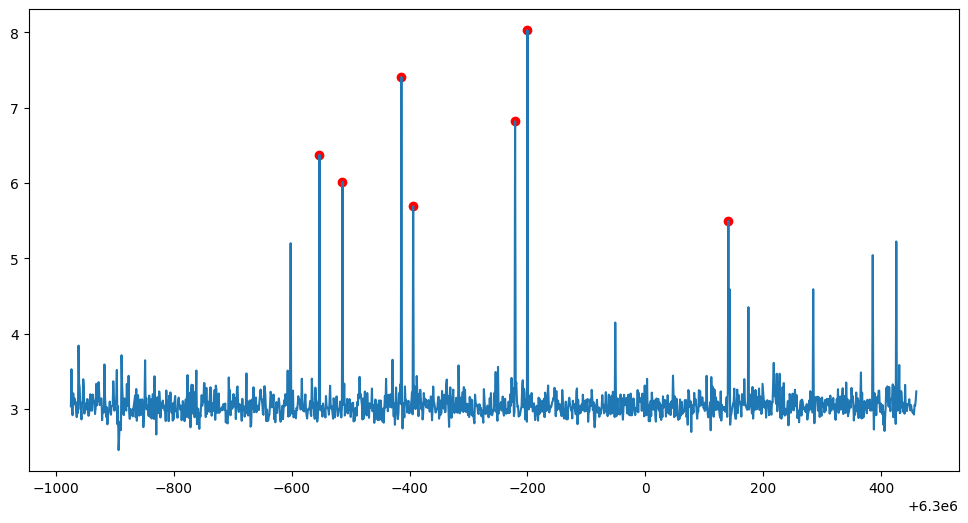

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Supposons que df_plot contient une colonne 'value' avec vos valeurs temporelles
# et 'date_hour' comme index temporel

# Normalisation des données
scaler = MinMaxScaler()
values = df_plot['avg_dns_time'].values.reshape(-1, 1)  # Remplacez 'value' par votre colonne cible
scaled_values = scaler.fit_transform(values)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # A ajuster selon vos données
X, y = create_sequences(scaled_values, SEQ_LENGTH)

# Séparation train/test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=20,  # A ajuster
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Prédictions sur l'ensemble de test
test_predictions = model.predict(X_test)
test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)

# Détermination du seuil d'anomalie
threshold = np.max(test_mae_loss)  # Vous pouvez utiliser un percentile (np.percentile)

# Création des séquences pour l'ensemble complet
full_X, full_y = create_sequences(scaled_values, SEQ_LENGTH)
full_predictions = model.predict(full_X)
full_mae_loss = np.mean(np.abs(full_predictions - full_y), axis=1)

# Détection des anomalies
anomalies = full_mae_loss > threshold
anomaly_indices = np.where(anomalies)[0]

plt.figure(figsize=(12, 6))
plt.plot(df_plot['avg_dns_time'], label='Valeurs réelles')
plt.scatter(
    df_plot.index[anomaly_indices + SEQ_LENGTH],  # Ajustement de l'index
    df_plot['avg_dns_time'].iloc[anomaly_indices + SEQ_LENGTH],
    color='red', label='Anomalies'
)
plt.axhline(y=scaler.inverse_transform([threshold])[0][0], color='green', linestyle='--', label='Seuil')
plt.legend()
plt.show()

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
ts = df_plot.set_index('date_hour')['avg_dns_time']
# Ajustement du modèle (ajuste les paramètres p,d,q,P,D,Q,s selon tes données)
model = SARIMAX(ts, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
results = model.fit()

# Prédiction et résidus
predictions = results.get_prediction(start=0, end=len(ts)-1)
predictions_mean = predictions.predicted_mean
residuals = ts - predictions_mean

# Détection d'anomalies
residual_std = np.std(residuals)
is_anomaly = abs(residuals) > 2.5 * residual_std

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [112]:
import plotly.express as px
import plotly.graph_objects as go

# Création d'un dataframe avec les résultats
results_df = pd.DataFrame({
    'date_hour': ts.index,
    'avg_dns_time': ts.values,
    'is_anomaly': is_anomaly.values
})

# Création du graphique
fig = go.Figure()

# Ajouter les points normaux
normal_df = results_df[~results_df['is_anomaly']]
fig.add_trace(
    go.Scatter(
        x=normal_df['date_hour'],
        y=normal_df['avg_dns_time'],
        mode='lines+markers',
        name='Normal',
        line=dict(color='blue'),
        marker=dict(size=5)
    )
)

# Ajouter les anomalies
anomalies_df = results_df[results_df['is_anomaly']]
fig.add_trace(
    go.Scatter(
        x=anomalies_df['date_hour'],
        y=anomalies_df['avg_dns_time'],
        mode='markers',
        name='Anomalies',
        marker=dict(color='red', size=10, symbol='circle')
    )
)

# Mise en page
fig.update_layout(
    title=f"Détection d'anomalies SARIMA - {peag} / {olt}",
    xaxis_title="Date/Heure",
    yaxis_title="avg_dns_time",
    legend_title="Statut",
    hovermode='closest'
)

fig.show()

# Afficher quelques statistiques
nb_anomalies = results_df['is_anomaly'].sum()
print(f"Nombre d'anomalies détectées: {nb_anomalies} ({nb_anomalies/len(results_df)*100:.2f}% des données)")

Nombre d'anomalies détectées: 17 (1.18% des données)


In [113]:
from prophet import Prophet
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# Préparation des données pour Prophet
# Assurez-vous que df_plot existe déjà dans votre environnement
df_prophet = df_plot[['date_hour', 'avg_dns_time']].rename(
    columns={'date_hour': 'ds', 'avg_dns_time': 'y'})

# Création et ajustement du modèle avec des paramètres modifiés
model = Prophet(
    changepoint_prior_scale=0.001,  # Modèle plus rigide
    seasonality_prior_scale=0.1,    # Moins d'emphase sur la saisonnalité
    daily_seasonality=True,         # Activer la saisonnalité quotidienne si pertinent
    interval_width=0.6              # Intervalle de confiance à 60%
)
model.fit(df_prophet)

# Prédiction
forecast = model.predict(df_prophet)

# Résidus et calcul du Z-score
df_prophet['residuals'] = df_prophet['y'] - forecast['yhat']
df_prophet['residuals_zscore'] = (df_prophet['residuals'] - df_prophet['residuals'].mean()) / df_prophet['residuals'].std()

# Méthode 1: Détection par Z-score avec seuil plus strict
threshold_zscore = 2.5
df_prophet['is_anomaly_zscore'] = abs(df_prophet['residuals_zscore']) > threshold_zscore

# Méthode 2: Anomalies par dépassement des bornes
df_prophet['yhat_upper'] = forecast['yhat_upper']
df_prophet['yhat_lower'] = forecast['yhat_lower']
df_prophet['is_anomaly_bounds'] = (df_prophet['y'] > df_prophet['yhat_upper']) | (df_prophet['y'] < df_prophet['yhat_lower'])

# Méthode 3: Détection manuelle basée sur l'écart-type
std_factor = 3.0
mean_y = df_prophet['y'].mean()
std_y = df_prophet['y'].std()
df_prophet['is_anomaly_manual'] = abs(df_prophet['y'] - mean_y) > (std_factor * std_y)

# Visualisation
fig = go.Figure()

# Valeurs normales
fig.add_trace(
    go.Scatter(
        x=df_prophet['ds'],
        y=df_prophet['y'],
        mode='lines+markers',
        name='Valeurs normales',
        marker=dict(color='blue', size=4),
        line=dict(color='blue', width=1),
        visible=True
    )
)

# Prédiction
fig.add_trace(
    go.Scatter(
        x=df_prophet['ds'],
        y=forecast['yhat'],
        mode='lines',
        name='Tendance + Saisonnalité (Prophet)',
        line=dict(color='green', width=2)
    )
)

# Intervalle de confiance
fig.add_trace(
    go.Scatter(
        x=df_prophet['ds'].tolist() + df_prophet['ds'].tolist()[::-1],
        y=forecast['yhat_upper'].tolist() + forecast['yhat_lower'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(0,100,80,0)'),
        name='Intervalle de confiance'
    )
)

# Anomalies détectées par les bornes
anomalies_bounds = df_prophet[df_prophet['is_anomaly_bounds']]
if len(anomalies_bounds) > 0:
    fig.add_trace(
        go.Scatter(
            x=anomalies_bounds['ds'],
            y=anomalies_bounds['y'],
            mode='markers',
            name='Anomalies (bornes)',
            marker=dict(color='orange', size=10, symbol='diamond')
        )
    )

# Anomalies détectées par Z-score
anomalies_zscore = df_prophet[df_prophet['is_anomaly_zscore']]
if len(anomalies_zscore) > 0:
    fig.add_trace(
        go.Scatter(
            x=anomalies_zscore['ds'],
            y=anomalies_zscore['y'],
            mode='markers',
            name='Anomalies (Z-score)',
            marker=dict(color='red', size=10, symbol='circle')
        )
    )

# Anomalies détectées par méthode manuelle
anomalies_manual = df_prophet[df_prophet['is_anomaly_manual']]
if len(anomalies_manual) > 0:
    fig.add_trace(
        go.Scatter(
            x=anomalies_manual['ds'],
            y=anomalies_manual['y'],
            mode='markers',
            name='Anomalies (méthode manuelle)',
            marker=dict(color='purple', size=10, symbol='x')
        )
    )

# Mise en page
# Si les variables peag et olt existent dans votre environnement
try:
    title = f"Détection d'anomalies avec Prophet - {peag} / {olt}"
except NameError:
    title = "Détection d'anomalies avec Prophet"

fig.update_layout(
    title=title,
    xaxis_title="Date/Heure",
    yaxis_title="avg_dns_time",
    hovermode='closest',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Ajouter un bouton pour filtrer les anomalies
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.1,
            y=1.15,
            buttons=list([
                dict(
                    label="Tout afficher",
                    method="update",
                    args=[{"visible": [True, True, True, True, True, True]},
                          {"title": title}]
                ),
                dict(
                    label="Afficher Z-score",
                    method="update",
                    args=[{"visible": [True, True, True, False, True, False]},
                          {"title": f"{title} (Anomalies Z-score)"}]
                ),
                dict(
                    label="Afficher bornes Prophet",
                    method="update",
                    args=[{"visible": [True, True, True, True, False, False]},
                          {"title": f"{title} (Anomalies bornes)"}]
                ),
                dict(
                    label="Afficher manuel",
                    method="update",
                    args=[{"visible": [True, True, True, False, False, True]},
                          {"title": f"{title} (Anomalies manuelles)"}]
                )
            ]),
        )
    ]
)

fig.show()

# Statistiques des différentes méthodes
print("\n=== RÉSULTATS DE LA DÉTECTION D'ANOMALIES ===")

# Méthode 1: Z-score
nb_anomalies_zscore = df_prophet['is_anomaly_zscore'].sum()
print(f"\n1. Méthode Z-score (seuil: {threshold_zscore})")
print(f"Nombre d'anomalies détectées: {nb_anomalies_zscore} ({nb_anomalies_zscore/len(df_prophet)*100:.2f}% des données)")

if nb_anomalies_zscore > 0:
    print(f"Les {min(5, nb_anomalies_zscore)} anomalies les plus significatives:")
    top_anomalies_zscore = df_prophet[df_prophet['is_anomaly_zscore']].copy()
    top_anomalies_zscore['amplitude'] = abs(top_anomalies_zscore['residuals'])
    top_anomalies_zscore = top_anomalies_zscore.sort_values(by='amplitude', ascending=False).head(5)

    for i, row in top_anomalies_zscore.iterrows():
        predicted = forecast.loc[forecast['ds'] == row['ds'],

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9urzbn7a/nha8nv1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9urzbn7a/r8kowzur.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56525', 'data', 'file=/tmp/tmp9urzbn7a/nha8nv1n.json', 'init=/tmp/tmp9urzbn7a/r8kowzur.json', 'output', 'file=/tmp/tmp9urzbn7a/prophet_model1_260ma4/prophet_model-20250416182909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Nombre d'anomalies détectées (bornes): 0 (0.00% des données)
Les 0 anomalies les plus significatives (bornes):


ValueError: NaTType does not support strftime

## Data Scoring

### EDA

In [ ]:
df_scoring.nunique()

,0
date_hour,1488
code_departement,96
olt_model,7
olt_name,6061
peag_nro,3176
boucle,537
dsp,32
pebib,211
nb_test_scoring,185
avg_latence_scoring,54734


In [ ]:
df_scoring.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8313430 entries, 0 to 9096907
Data columns (total 14 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date_hour            datetime64[ns]
 1   code_departement     object        
 2   olt_model            object        
 3   olt_name             object        
 4   peag_nro             object        
 5   boucle               object        
 6   dsp                  object        
 7   pebib                object        
 8   nb_test_scoring      int64         
 9   avg_latence_scoring  float64       
 10  std_latence_scoring  float64       
 11  avg_score_scoring    float64       
 12  std_score_scoring    float64       
 13  nb_client_total      int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(7)
memory usage: 951.4+ MB


Le même seuil de contamination par olt et par peag n'obtiens pas les mêmes résultats, par PEAG on doit mettre un seuil plus élevé pour capter les points les plus loins du nuage

In [ ]:
df_scoring.isna().sum()

,0
date_hour,0
code_departement,117
olt_model,8095
olt_name,0
peag_nro,7
boucle,7
dsp,0
pebib,4056844
nb_test_scoring,0
avg_latence_scoring,783478


In [ ]:
df_scoring['nb_test_scoring'].describe()

,nb_test_scoring
count,9.096908e+06
mean,8.786119e+00
std,1.322018e+01
min,0.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,1.000000e+01
max,2.050000e+02


In [ ]:
df_scoring = df_scoring[df_scoring.nb_test_scoring > 0]

In [ ]:
df_scoring.isna().sum()

,0
date_hour,0
code_departement,60
olt_model,7039
olt_name,0
peag_nro,3
boucle,3
dsp,0
pebib,3734849
nb_test_scoring,0
avg_latence_scoring,0


Histogrammes

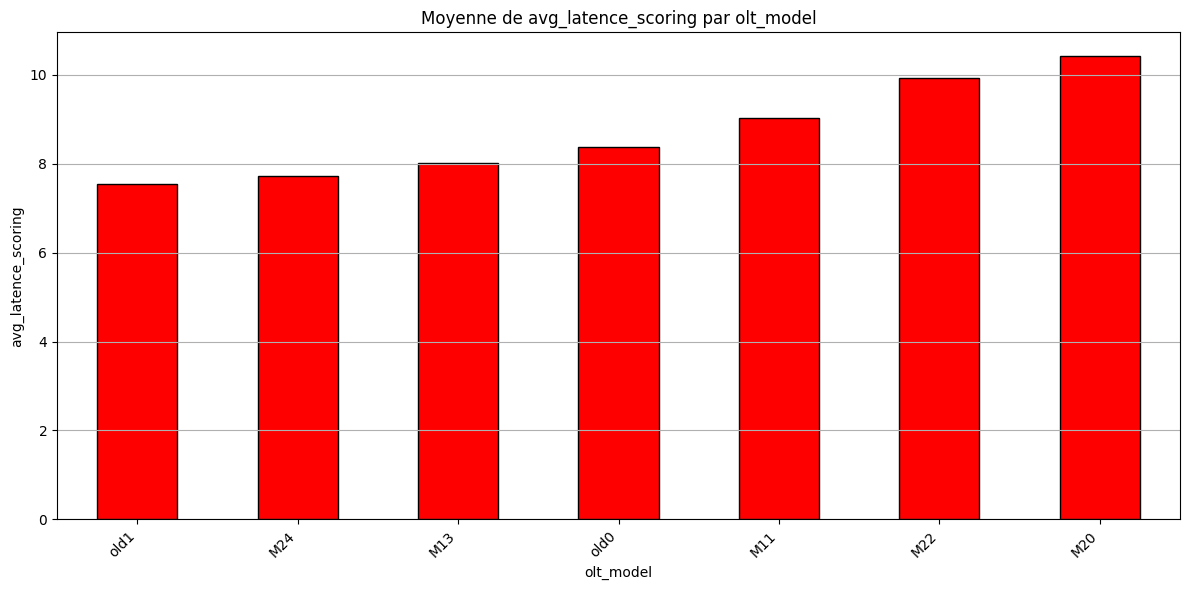

In [ ]:
# Calcul de la moyenne par modèle OLT
avg_lat_per_model = df_scoring.groupby("olt_model")["avg_latence_scoring"].mean().sort_values()

# Tracer le bar plot
plt.figure(figsize=(12, 6))
avg_lat_per_model.plot(kind="bar", color="red", edgecolor="black")
plt.title("Moyenne de avg_latence_scoring par olt_model")
plt.xlabel("olt_model")
plt.ylabel("avg_latence_scoring")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

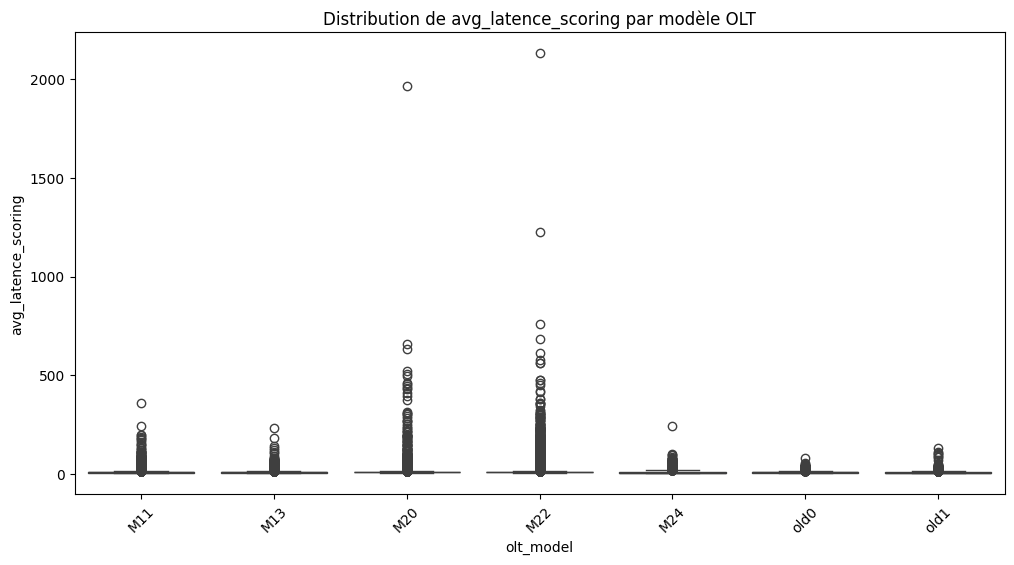

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scoring, x="olt_model", y="avg_latence_scoring")
plt.title("Distribution de avg_latence_scoring par modèle OLT")
plt.xticks(rotation=45)
plt.show()

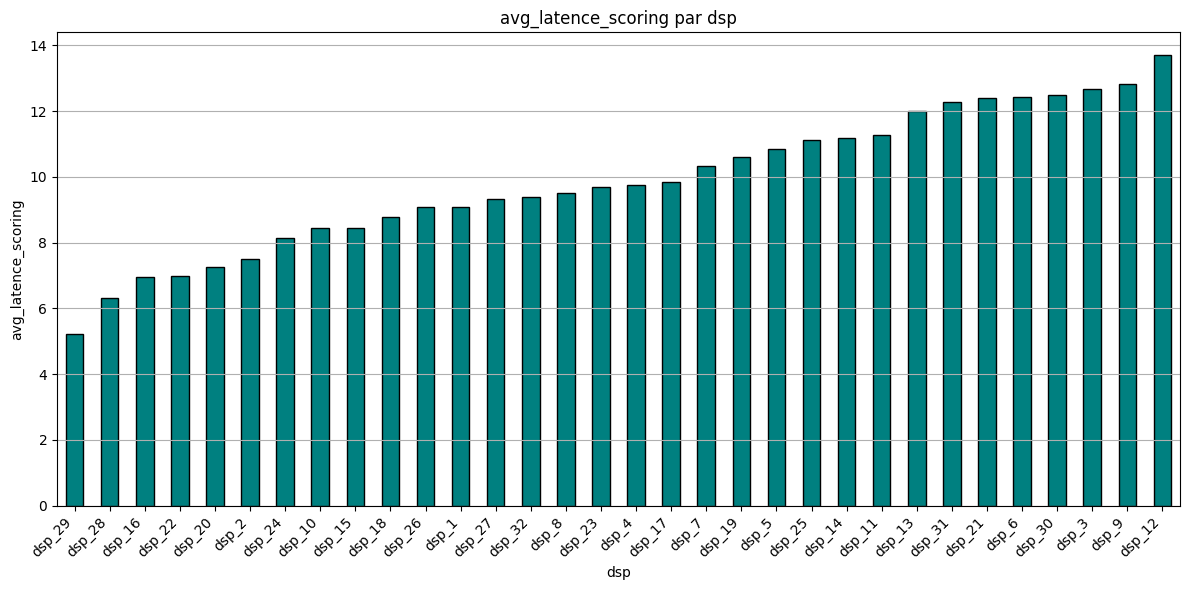

In [ ]:
import matplotlib.pyplot as plt

# Calcul de la moyenne par modèle OLT
avg_lat_per_model = df_scoring.groupby("dsp")["avg_latence_scoring"].mean().sort_values()

# Tracer le bar plot
plt.figure(figsize=(12, 6))
avg_lat_per_model.plot(kind="bar", color="teal", edgecolor="black")
plt.title("avg_latence_scoring par dsp")
plt.xlabel("dsp")
plt.ylabel("avg_latence_scoring")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

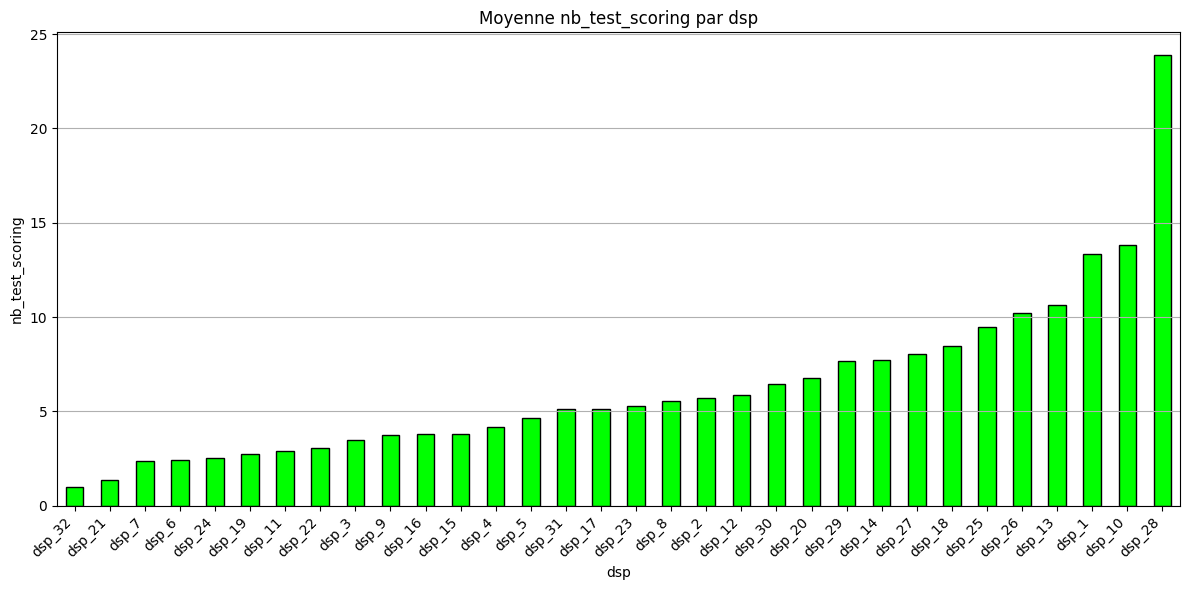

In [ ]:
import matplotlib.pyplot as plt

# Calcul de la moyenne par modèle OLT
avg_lat_per_model = df_scoring.groupby("dsp")["nb_test_scoring"].mean().sort_values()

# Tracer le bar plot
plt.figure(figsize=(12, 6))
avg_lat_per_model.plot(kind="bar", color="lime", edgecolor="black")
plt.title("Moyenne nb_test_scoring par dsp")
plt.xlabel("dsp")
plt.ylabel("nb_test_scoring")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

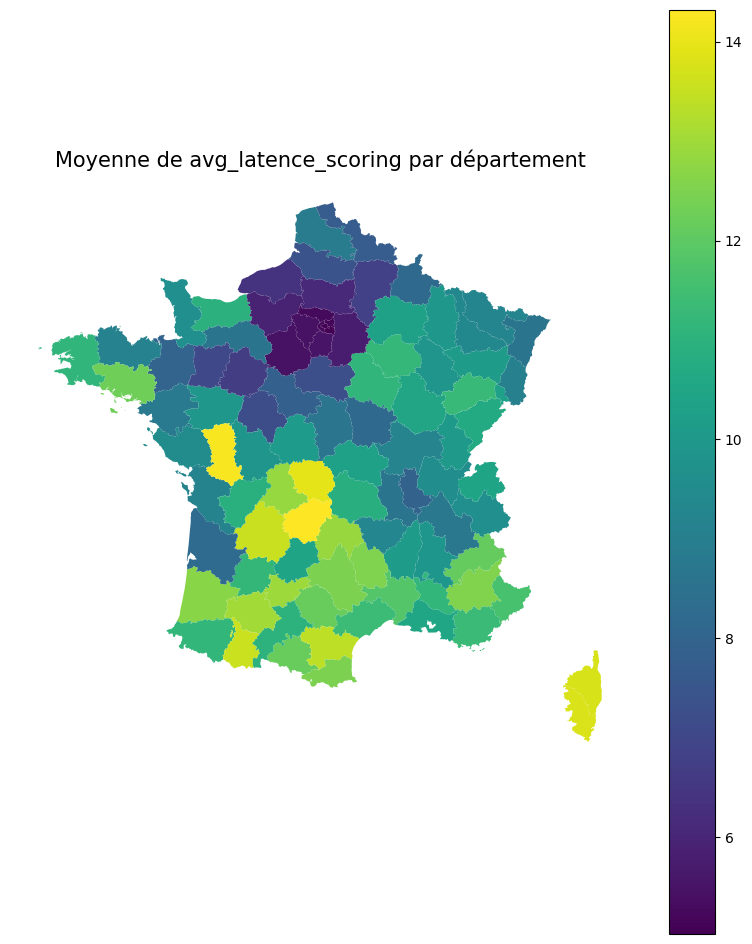

In [ ]:
import geopandas as gpd
# 1. Moyenne par département
df_dep_avg = df.groupby("code_departement", as_index=False)["avg_latence_scoring"].mean()

# 2. Charger la carte des départements
gdf_departements = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")

# 3. S'assurer que les deux colonnes sont de type string
gdf_departements["code"] = gdf_departements["code"].astype(str)
df_dep_avg["code_departement"] = df_dep_avg["code_departement"].astype(str)

# 4. Fusion
gdf_merged = gdf_departements.merge(df_dep_avg, left_on="code", right_on="code_departement")

# 5. Carte
fig, ax = plt.subplots(figsize=(10, 12))
gdf_merged.plot(column="avg_latence_scoring", cmap="viridis", legend=True, ax=ax)
ax.set_title("Moyenne de avg_latence_scoring par département", fontsize=15)
plt.axis("off")
plt.show()

Comme avant, agrégation de la data par OLT

In [ ]:
df_agg_scoring = df_scoring.groupby(["olt_name", "date_hour"], as_index=False).agg({
    "avg_latence_scoring": "mean",
    "avg_score_scoring": "mean",
    "nb_test_scoring": "sum",
    "nb_client_total": "sum"
})

In [ ]:
df_agg_scoring.isna().sum()

,0
olt_name,0
date_hour,0
avg_latence_scoring,0
avg_score_scoring,16
nb_test_scoring,0
nb_client_total,0


In [ ]:
df_agg_scoring = df_agg_scoring.dropna()

Nouvelles variables :
- ratio_test_clients : plus ce ratio est haut, plus les clients ont réalisé de tests. Ça peut signaler un mécontentement ou une dégradation ressentie.

- score_per_test : indique la performance moyenne des tests individuellement.

- latence_per_test : utile pour identifier si un nombre anormal de tests fait exploser la latence moyenne.



In [ ]:
df_agg_scoring["ratio_test_clients"] = df_agg_scoring["nb_test_scoring"] / df_agg_scoring["nb_client_total"]
df_agg_scoring["score_per_test"] = df_agg_scoring["avg_score_scoring"] / df_agg_scoring["nb_test_scoring"]
df_agg_scoring["latence_per_test"] = df_agg_scoring["avg_latence_scoring"] / df_agg_scoring["nb_test_scoring"]



In [ ]:
from sklearn.ensemble import IsolationForest

# Choix des features pertinentes
features = ["avg_score_scoring", "ratio_test_clients", "latence_per_test", "score_per_test", "nb_test_scoring", "nb_client_total"]

# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.01, random_state=42)
df_agg_scoring["anomaly"] = model.fit_predict(df_agg_scoring[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring[df_agg_scoring["anomaly"] == -1]

In [ ]:
olt_sample = df_anomalies["olt_name"].unique()[0]  # ou choisis manuellement une valeur
print("OLT sélectionné :", olt_sample)
df_olt = df_agg_scoring[df_agg_scoring["olt_name"] == olt_sample]

OLT sélectionné : 01_olt_18


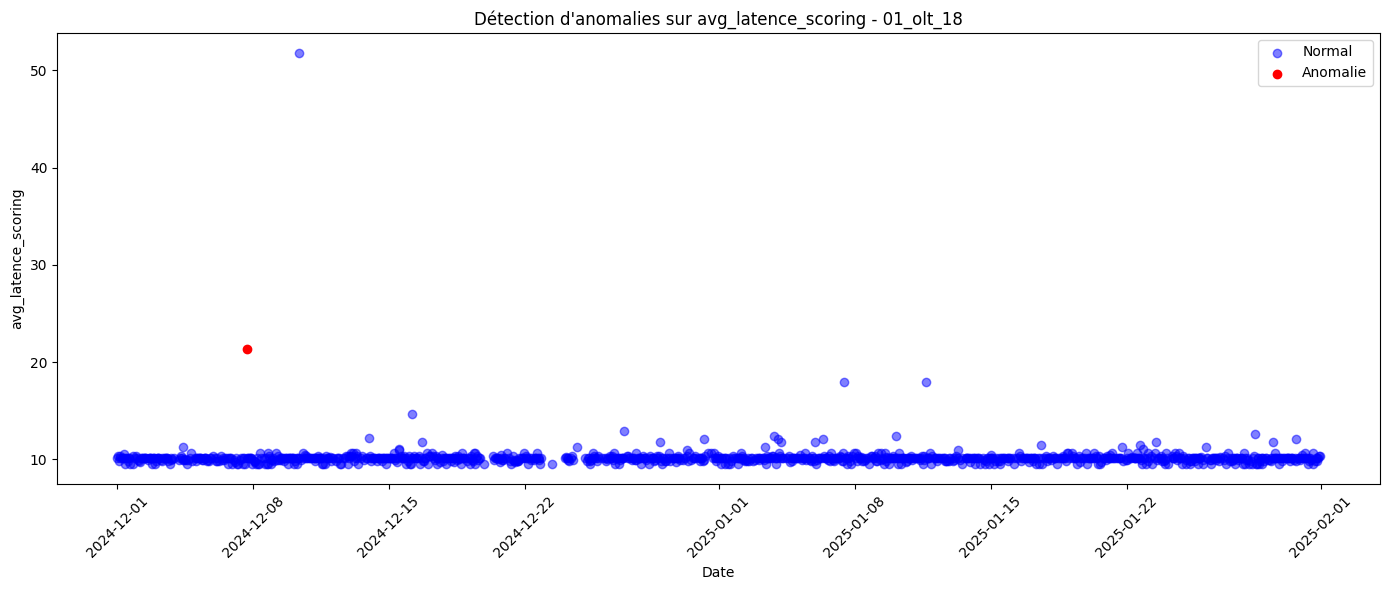

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

On arrive pas à capter le point le plus éloigné, ni les autres potentiellement anormaux : on va essayer de modifier la contamination, par auto puis en la passant de 0.01 à 0.015

In [ ]:
from sklearn.ensemble import IsolationForest



# Isolation Forest
model = IsolationForest(n_estimators=120, contamination='auto', random_state=42)
df_agg_scoring["anomaly"] = model.fit_predict(df_agg_scoring[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring[df_agg_scoring["anomaly"] == -1]

In [ ]:
df_olt = df_agg_scoring[df_agg_scoring["olt_name"] == "01_olt_18"]

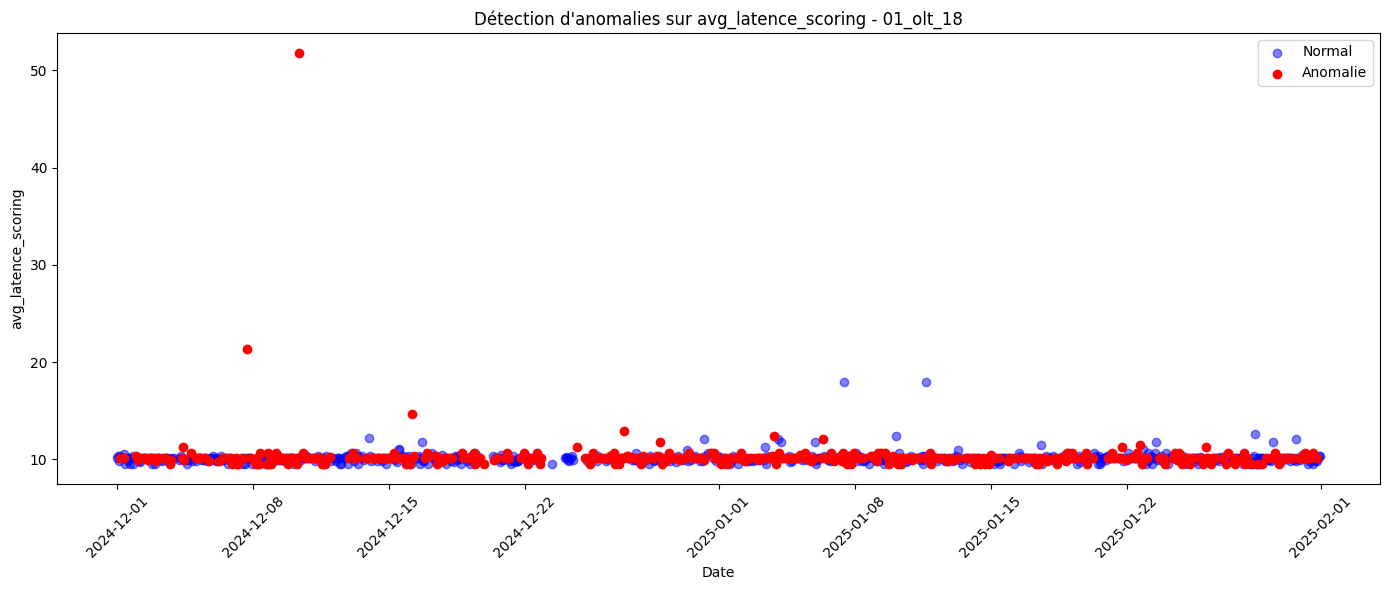

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le paramètre auto n'est pas du tout adapté

In [ ]:
from sklearn.ensemble import IsolationForest

# Choix des features pertinentes


# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.015, random_state=42)
df_agg_scoring["anomaly"] = model.fit_predict(df_agg_scoring[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring[df_agg_scoring["anomaly"] == -1]

In [ ]:
df_olt = df_agg_scoring[df_agg_scoring["olt_name"] == "01_olt_18"]

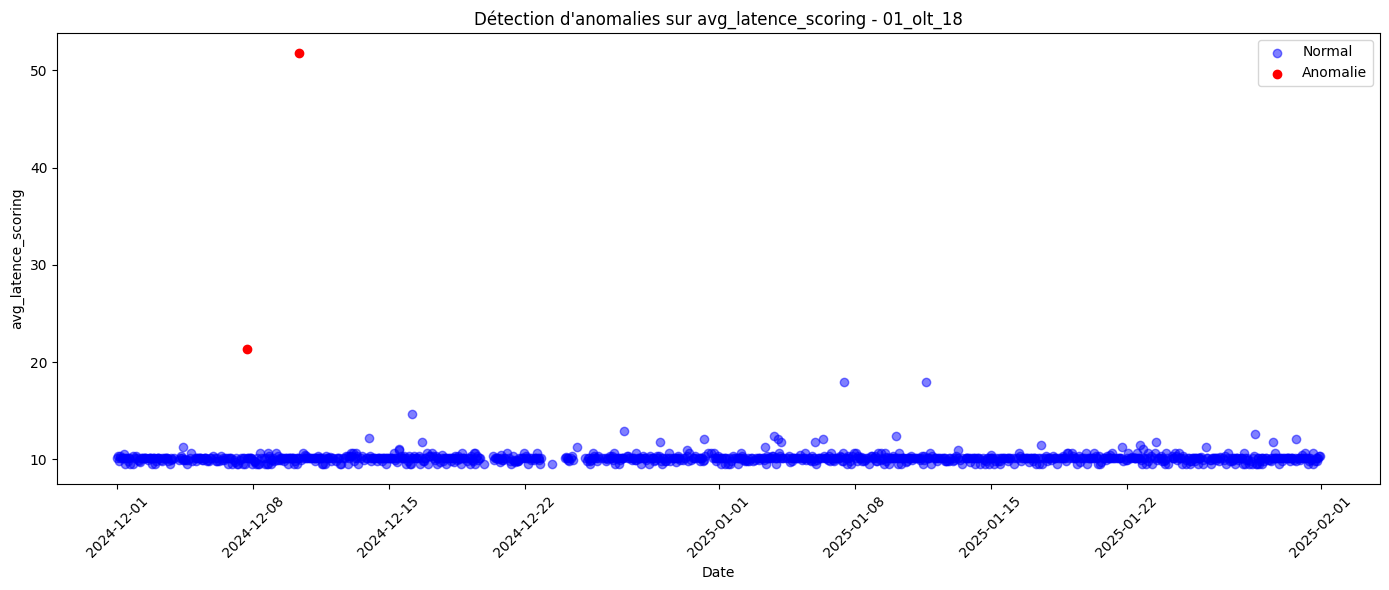

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_olt[df_olt["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_olt[df_olt["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {olt_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Un meilleur seuil peut optimiser la détection (on peut voir deux points distincts autour du 01/08/2025)

# Agrégation par PEAG

In [ ]:
df_agg_scoring_peag = df_scoring.groupby(["peag_nro", "date_hour"], as_index=False).agg({
    "avg_latence_scoring": "mean",
    "avg_score_scoring": "mean",
    "nb_test_scoring": "sum",
    "nb_client_total": "sum"
})

In [ ]:
df_agg_scoring_peag.isna().sum()

,0
peag_nro,0
date_hour,0
avg_latence_scoring,0
avg_score_scoring,3
nb_test_scoring,0
nb_client_total,0


In [ ]:
df_agg_scoring_peag = df_agg_scoring_peag.dropna()

In [ ]:
df_agg_scoring_peag["ratio_test_clients"] = df_agg_scoring_peag["nb_test_scoring"] / df_agg_scoring_peag["nb_client_total"]
df_agg_scoring_peag["score_per_test"] = df_agg_scoring_peag["avg_score_scoring"] / df_agg_scoring_peag["nb_test_scoring"]
df_agg_scoring_peag["latence_per_test"] = df_agg_scoring_peag["avg_latence_scoring"] / df_agg_scoring_peag["nb_test_scoring"]

In [ ]:
from sklearn.ensemble import IsolationForest

# Choix des features pertinentes
features = ["avg_score_scoring", "ratio_test_clients", "latence_per_test", "score_per_test", "nb_test_scoring", "nb_client_total"]

# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.01, random_state=42)
df_agg_scoring_peag["anomaly"] = model.fit_predict(df_agg_scoring_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring_peag[df_agg_scoring_peag["anomaly"] == -1]

In [ ]:
peag_sample = df_anomalies["peag_nro"].unique()[0]  # ou choisis manuellement une valeur
print("PEAG sélectionné :", peag_sample)
df_peag = df_agg_scoring_peag[df_agg_scoring_peag["peag_nro"] == peag_sample]

PEAG sélectionné : 01_peag_16


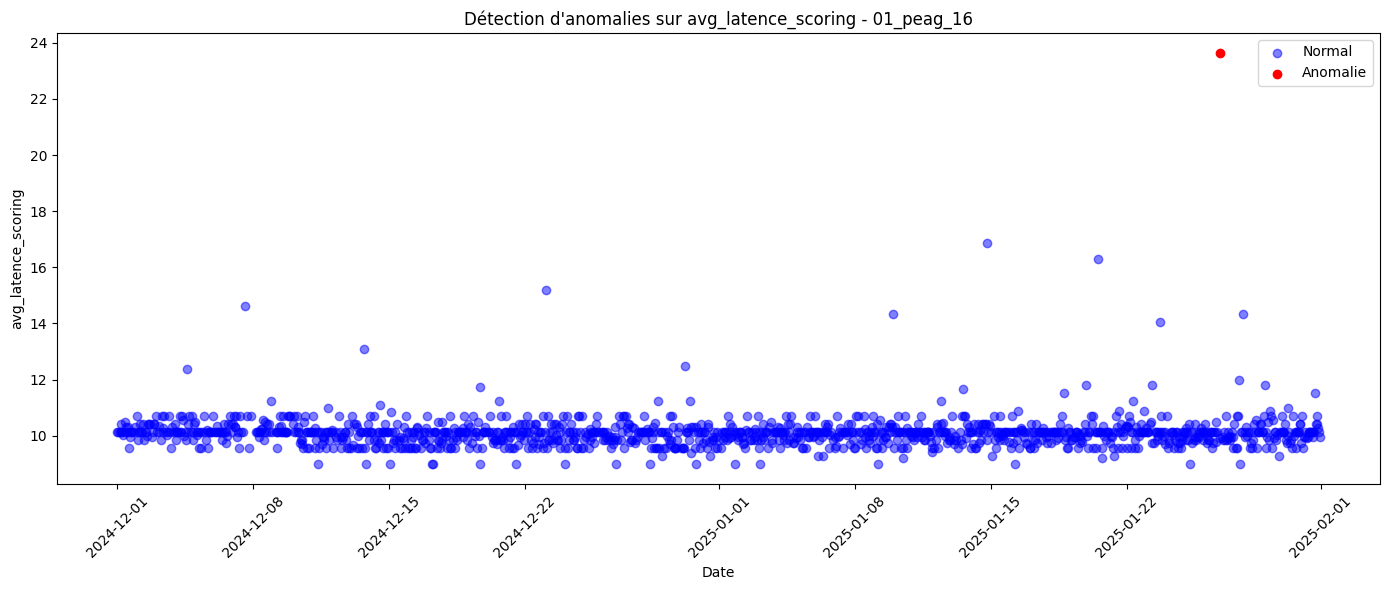

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Comme par OLT, le seuil n'est visiblement pas bon

In [ ]:
from sklearn.ensemble import IsolationForest



# Isolation Forest
model = IsolationForest(n_estimators=120, contamination='auto', random_state=42)
df_agg_scoring_peag["anomaly"] = model.fit_predict(df_agg_scoring_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring_peag[df_agg_scoring_peag["anomaly"] == -1]

In [ ]:
df_peag = df_agg_scoring_peag[df_agg_scoring_peag["peag_nro"] == "01_peag_16"]

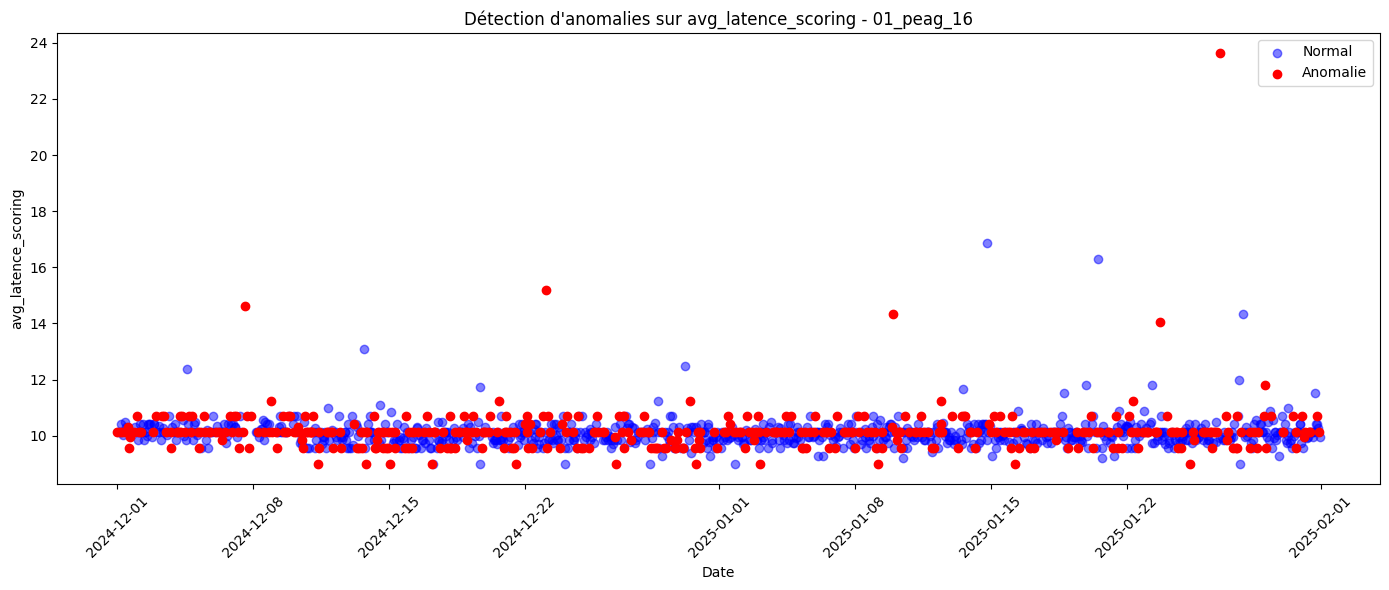

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le seuil auto est mauvais, on va changer le seuil par la suite

In [ ]:
from sklearn.ensemble import IsolationForest



# Isolation Forest
model = IsolationForest(n_estimators=120, contamination=0.04, random_state=42)
df_agg_scoring_peag["anomaly"] = model.fit_predict(df_agg_scoring_peag[features])

# -1 = anomalie, 1 = normal
df_anomalies = df_agg_scoring_peag[df_agg_scoring_peag["anomaly"] == -1]

In [ ]:
df_peag = df_agg_scoring_peag[df_agg_scoring_peag["peag_nro"] == "01_peag_16"]

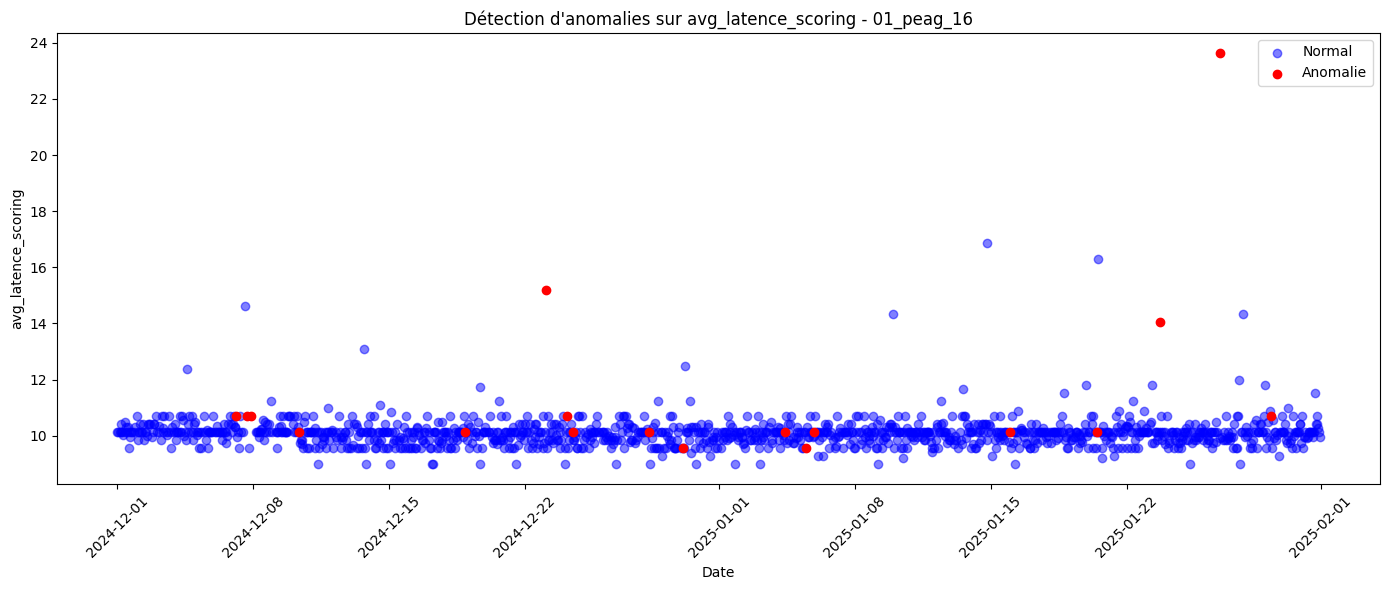

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Tracé des points normaux
normaux = df_peag[df_peag["anomaly"] == 1]
plt.scatter(normaux["date_hour"], normaux["avg_latence_scoring"], label="Normal", color="blue", alpha=0.5)

# Tracé des anomalies
anomalies = df_peag[df_peag["anomaly"] == -1]
plt.scatter(anomalies["date_hour"], anomalies["avg_latence_scoring"], color="red", label="Anomalie", zorder=5)

plt.title(f"Détection d'anomalies sur avg_latence_scoring - {peag_sample}")
plt.xlabel("Date")
plt.ylabel("avg_latence_scoring")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Pour la détection d'anomalies par scoring, le modèle d'isolation forest capte moins bien la donnée, il n'arrive pas à bien séparer les valeurs normales des valeurs aberrantes.